# Predicting Apartment Prices in Barcelona 2023
**by Eixample Team**: Maëlys Boudier, Tatiana Bakwenye, Mikel Gallo

## 0. Set Up

#### Import Packages

In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


#### Import Data

In [4]:
# Retrieve path and load the data
path = os.getcwd()
df = pd.read_csv(path+"/train.csv")
df_test = pd.read_csv(path+"/test.csv")

# Number of rows and columns
print('df train', df.shape)
print('df test', df_test.shape)

df.head(3)

df train (8000, 15)
df test (2000, 14)


,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price
0,9255,1.0,1.0,NaN,NaN,1956.0,3º - 1a,False,False,Sant Martí,2.0,True,True,NaN,1096
1,1562,4.0,1.0,133.0,west,1960.0,7º - 2a,False,False,Sants,4.0,False,False,2.0,1396
2,1671,2.0,3.0,137.0,NaN,2000.0,1º - 1a,False,True,Eixample,0.0,False,False,NaN,1263


## 1. Dataset Exploration

In [5]:
# Function for calculating frequency table
def freq_table(df,group_col,id_col):
    qty = pd.DataFrame(df.groupby(group_col,dropna=False)[id_col].count()).reset_index()
    qty['total'] = qty[id_col].sum()
    qty['perc']= round(qty[id_col] / qty['total'],4)
    qty['accum'] = round(qty['perc'].expanding().sum(),3) #Calculating running sum
    return qty

# Function for calculating conditional expectation function table
def CEF_table(df,group_col,id_col):
    qty = pd.DataFrame(df.groupby(group_col,dropna=False)[id_col].mean()).reset_index()
    return qty

In [67]:
def groupby_table(dataset,M):
    #Plotting both perc and accum
    #Plot both mean  and median as lines
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7, figsize=(14,8))
    dataset.plot(x= M, y='price' , kind= 'bar', ax=ax1,fontsize=8)
    dataset.plot(x=M, y='num_crimes' , kind= 'bar', ax=ax2,fontsize=8)
    dataset.plot(x=M, y='num_rooms', kind = 'bar',ax = ax3,fontsize=8)
    dataset.plot(x=M, y='num_baths' , kind= 'bar', ax=ax4,fontsize=8)
    dataset.plot(x=M, y='square_meters' , kind= 'bar', ax=ax5,fontsize=8)
    dataset.plot(x=M, y='year_built' , kind= 'bar', ax=ax6,fontsize=8)
    dataset.plot(x=M, y='year_built' , kind= 'bar', ax=ax7,fontsize=8)

    plt.xticks(rotation=90)
    plt.show()

In [25]:

# Define a function to plot histograms
def plot_hist_mult(data, var1, var2, bins):
    #sns.set(style="ticks") # Set Seaborn style
    #sns.set(style="darkgrid")
    sns.set(style="dark")


    fig, axes = plt.subplots(var1, var2)

    for i, el in enumerate(list(data.columns.values)):
        ax = data[el].plot.hist(ax=axes.flatten()[i], bins=bins, color='skyblue', edgecolor='black')  # Add color and edgecolor
        ax.set_title(f'Histogram of {el}', fontsize=12)
        ax.set_xlabel(el, fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)

    fig.set_size_inches(12, 10)
    plt.tight_layout()  # Improve spacing
    plt.show()


# Define a function to plot box plots
def plot_box_mult(data, var1, var2):
    sns.set(style="dark") # Set Seaborn style

    fig, axes = plt.subplots(var1, var2)

    for i, el in enumerate(list(data.columns.values)):
        ax = data.boxplot(el, ax=axes.flatten()[i], fontsize='large', patch_artist=True, boxprops={'facecolor': 'white', 'color': 'black'})  # Add color
        ax.set_title(f'Boxplot of {el}', fontsize=12)  # Add title
        ax.set_ylabel(f'{el} Value', fontsize=10)  # Label y-axis
        
         # Customize the color of the median line (percentile 50)
        median_line = ax.lines[4]  
        median_line.set_color('red') 

    fig.set_size_inches(12, 10)
    plt.tight_layout()  # Improve spacing
    plt.show()


#### Types of Variables and Number of non-NaN

This allows us to determine which variables are non-numerical: orientation, door, is_furnished, has_pool, neighborhood, has_ac, accepts_pets all will need further analysis.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   object 
 8   has_pool          7844 non-null   object 
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   object 
 12  accepts_pets      7845 non-null   object 
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 937.6+ KB


In [4]:
# Descriptive statistics of the quantitative data
df.describe()

,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price
count,8000.000000,8000.000000,7840.000000,7845.000000,7830.000000,7840.000000,1411.000000,8000.000000
mean,5012.506875,2.868500,1.988265,108.031995,1985.321073,2.803444,1.982991,1099.616250
std,2887.649416,5.300469,0.815943,38.671420,20.591437,3.447714,0.803182,271.686617
min,2.000000,1.000000,1.000000,-100.000000,1950.000000,0.000000,1.000000,195.000000
25%,2512.750000,1.000000,1.000000,78.000000,1968.000000,0.000000,1.000000,905.750000
50%,5014.500000,2.000000,2.000000,110.000000,1985.000000,1.000000,2.000000,1104.000000
75%,7505.250000,4.000000,3.000000,140.000000,2003.000000,6.000000,3.000000,1295.000000
max,10000.000000,97.000000,3.000000,170.000000,2021.000000,10.000000,3.000000,2095.000000


### Exploring distributions of numerical variables

In [31]:
num_vars = ['price','num_rooms','num_baths','square_meters','num_crimes','year_built','num_supermarkets']

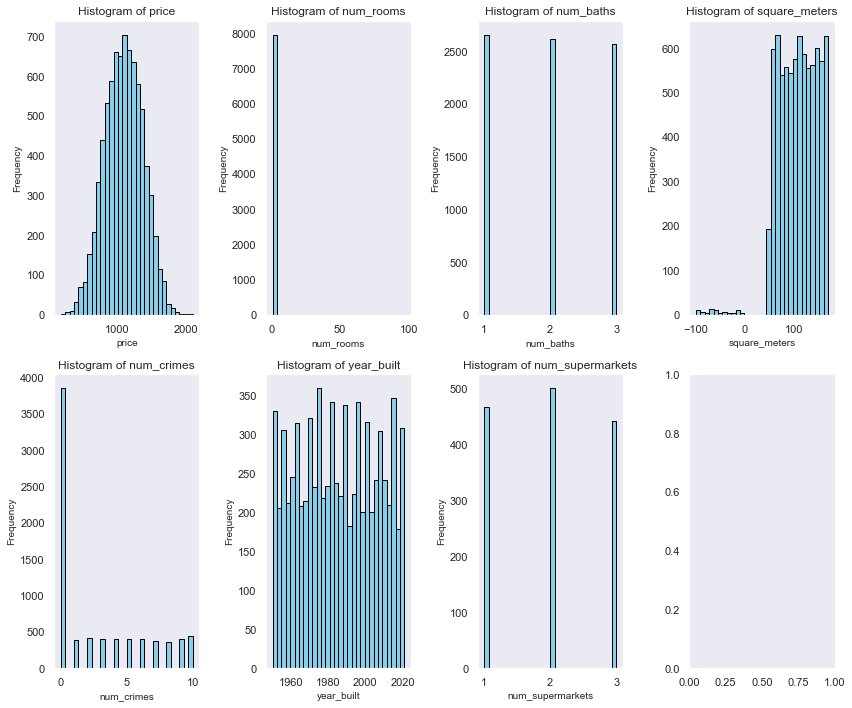

In [32]:
plot_hist_mult(df[num_vars],2,4,30)

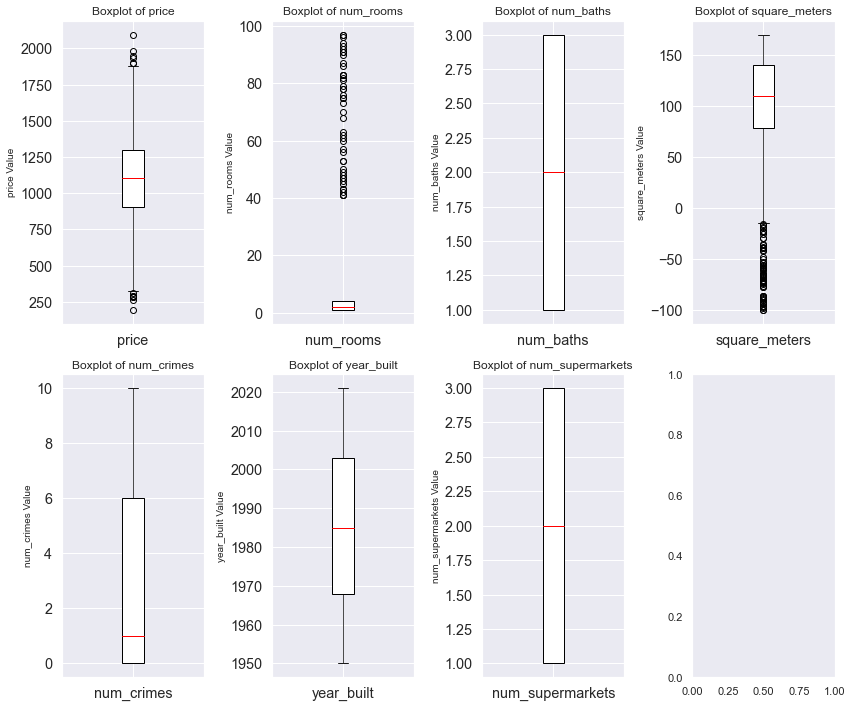

In [33]:
plot_box_mult(df[num_vars],2,4)

- Price follows a gaussian distribution with few outliers.
- Num_Rooms have extreme observations that range btw 40 and 100.
- Square meters have multiple negative observations.

In [43]:
#Make copy for analysis purposes
df_a = df.copy()

## Studying Neighborhoods

- Group by Neighbourhood and calculate the means of numerical variables.
- Additionally, order the orientation based on their avg price in descending order.

In [34]:
ng_price_vs_crime = df.groupby(['neighborhood'])[num_vars].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [35]:
ng_price_vs_crime

,neighborhood,price,num_rooms,num_baths,square_meters,num_crimes,year_built,num_supermarkets
0,Sarrià-Sant Gervasi,1151.980,2.926,1.996,108.967,0.628,1985.141,1.959
1,Eixample,1143.737,2.836,2.025,108.258,0.921,1986.240,1.971
2,Les Cors,1127.503,2.938,1.973,107.638,1.429,1985.629,1.968
3,Gràcia,1117.152,2.942,1.985,107.697,2.215,1984.780,1.875
4,Horta,1108.239,2.806,1.954,107.861,2.541,1984.480,1.941
5,Ciutat Vella,1096.231,2.666,1.982,108.757,3.077,1985.783,2.007
6,Sants,1088.028,2.772,1.989,110.525,3.673,1985.586,2.045
7,Sant Martí,1067.832,3.186,1.971,105.637,3.497,1985.398,2.036
8,Sant Andreu,1067.313,2.589,2.027,109.306,4.488,1984.603,1.922
9,Nou Barris,1038.453,2.998,1.975,106.384,5.119,1985.443,2.062


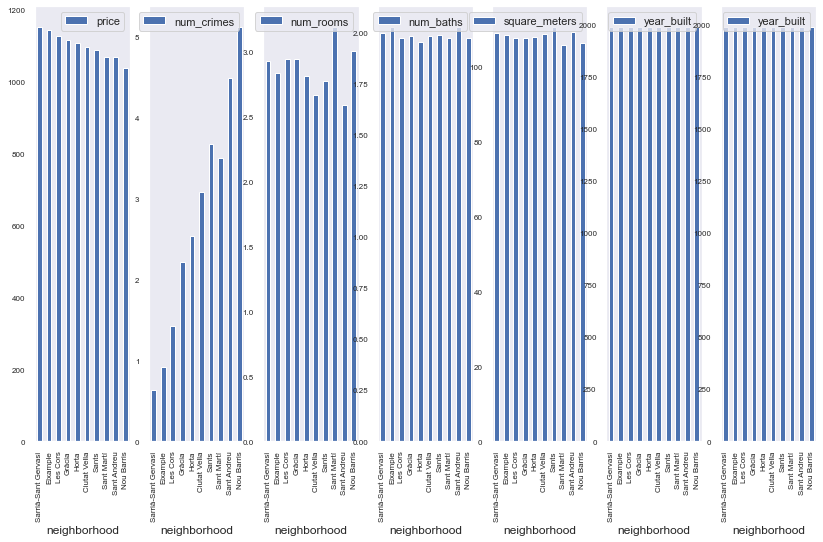

In [52]:
groupby_table(ng_price_vs_crime,'neighborhood')

- Strong positive association between neighborhood and price.
- Similarly, we can see that the higher the avg price of the neighborhood the lower the crime rate.

## Studying Orientation

- Group by orientation and calculate the means of numerical variables.
- Additionally, order the orientation based on their avg price in descending order.

In [68]:
df_a['orientation'] = df_a['orientation'].replace('soxth','south')

In [69]:
ng_price_vs_orientation = df_a.groupby(['orientation'])[num_vars].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [70]:
ng_price_vs_orientation

,orientation,price,num_rooms,num_baths,square_meters,num_crimes,year_built,num_supermarkets
0,south,1102.145,3.007,1.979,108.288,2.802,1984.590,2.055
1,west,1098.560,2.953,2.003,108.457,2.919,1984.350,1.908
2,north,1096.452,2.836,1.965,106.538,2.593,1985.405,1.950
3,east,1093.642,2.794,1.985,106.633,2.809,1985.965,1.946


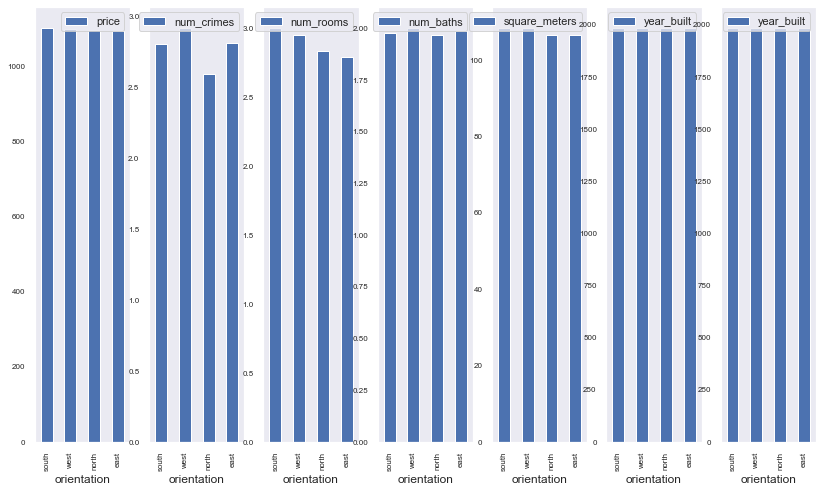

In [71]:
groupby_table(ng_price_vs_orientation,'orientation')

- No interesting associations between orientation and our numeric metrics

## Studying floor

In [77]:
df_a['floor'] = df_a['door'].str[:1]

In [78]:
ng_price_vs_floor = df_a.groupby(['floor'])[num_vars].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [79]:
ng_price_vs_floor.head()

,floor,price,num_rooms,num_baths,square_meters,num_crimes,year_built,num_supermarkets
0,9,1132.555,2.903,2.021,108.629,2.870,1985.267,1.978
1,7,1128.077,2.850,1.996,109.745,2.892,1986.015,2.097
2,8,1123.154,2.923,2.046,107.281,2.708,1986.168,1.944
3,6,1112.515,2.834,1.978,107.195,2.605,1984.448,1.935
4,1,1096.677,2.849,1.975,107.160,2.863,1985.341,2.017


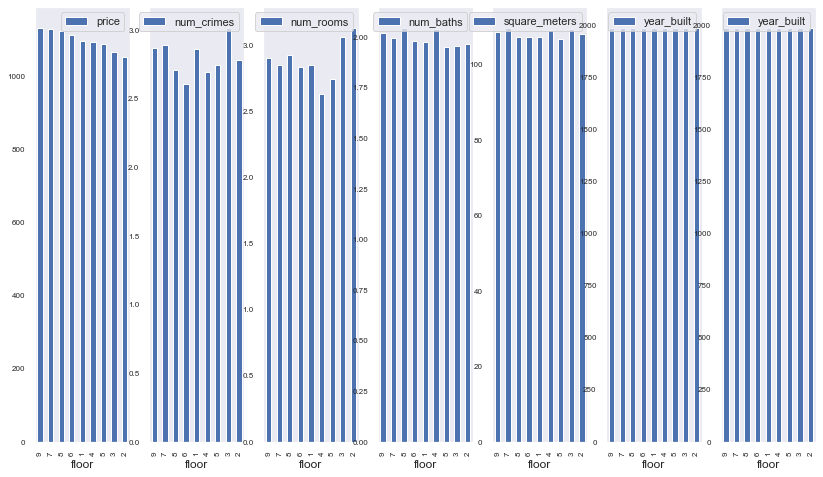

In [80]:
groupby_table(ng_price_vs_floor,'floor')

- Direct association between floor and price. Higher floors tend to be more expensive than middle or lower ones.

#### Target Variable Price Follows a Normal Distribution

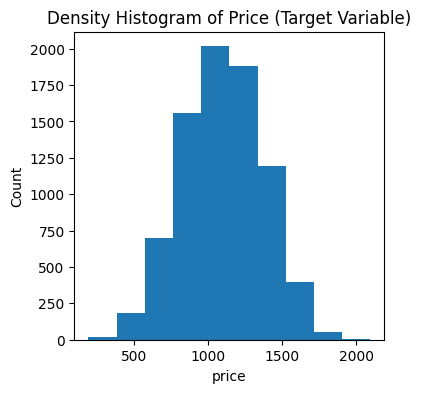

In [5]:
# Distribution of the target variable
plt.figure(figsize=(4, 4))  
plt.hist(df['price'], bins=10)
plt.title('Density Histogram of Price (Target Variable)')
plt.xlabel('price')
plt.ylabel('Count')
plt.show()

### Correlation amongst quantitative variables

Text(0.5, 1.0, 'Correlation Matrix (Quantitative Variables)')

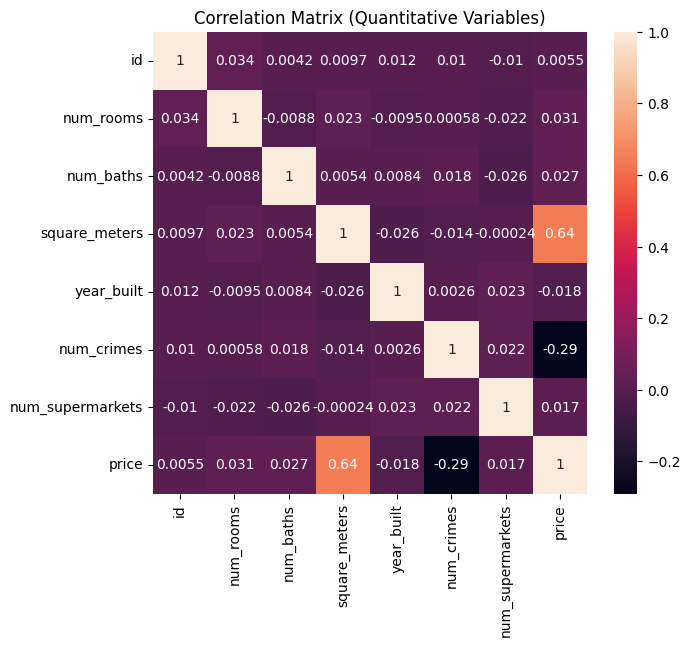

In [6]:
# Correlations among the variables 
df_for_heatmap = df.drop(columns=['door', 'orientation', 'neighborhood', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets'])
df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(7,6))
ax = sns.heatmap(df_for_heatmap_corr, annot = True, )
plt.title('Correlation Matrix (Quantitative Variables)')

## 2. Handling Missing Data and Categorical Variables

#### Visualizing Missing Data

First we see a plot with number of non-NaN data above the bars representing percentage of non-NaN data for the train dataframe. Then, we plotted nullity correlations amongst NA which is how strongly the absence (or presence) of one feature may affect the presence of another, but the correlations were all weak. The percentage of missing values for each feature aligns with the percentages in the train dataframe. 

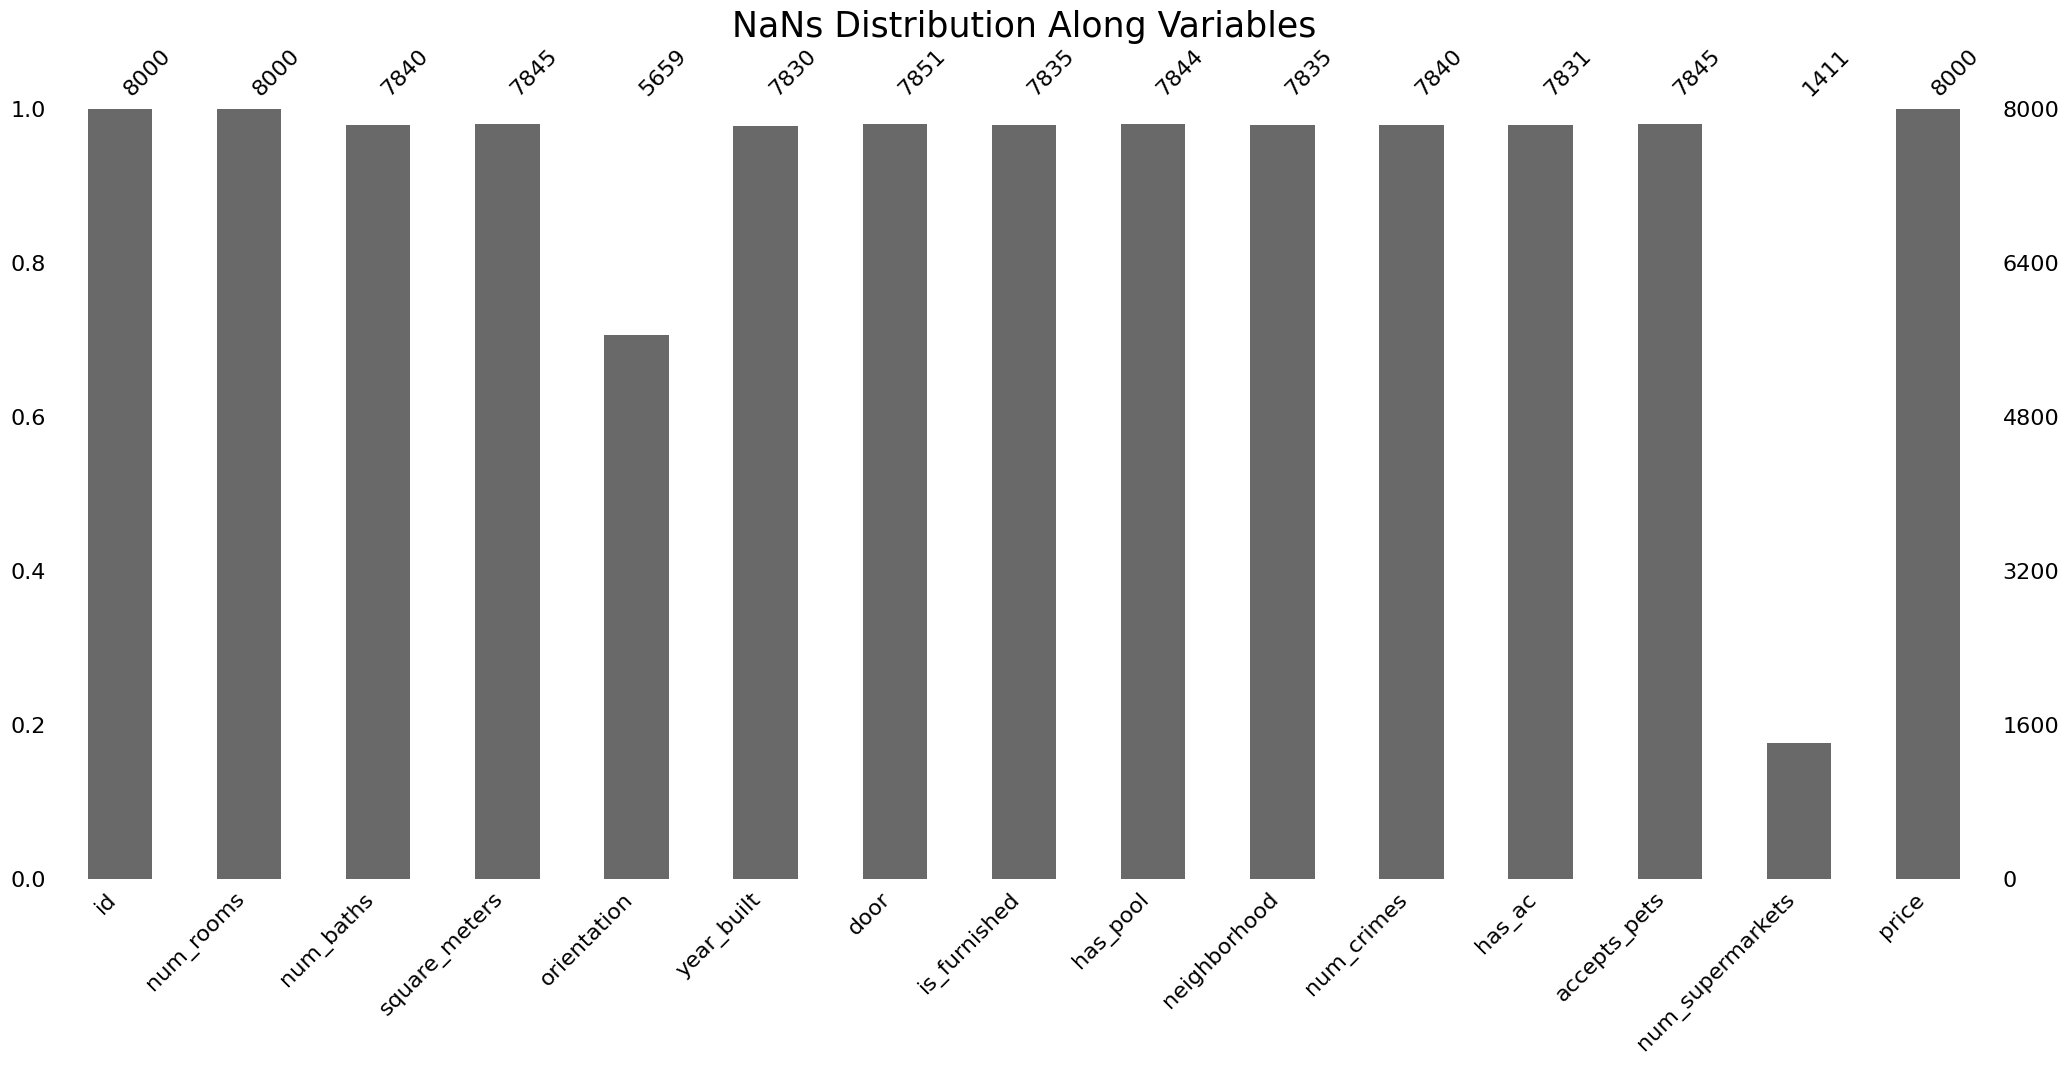

In [7]:
# Visualize NaNs distribution along the variables
msno.bar(df)

# Add a title to the plot
plt.title('NaNs Distribution Along Variables', fontsize=25)
plt.show()

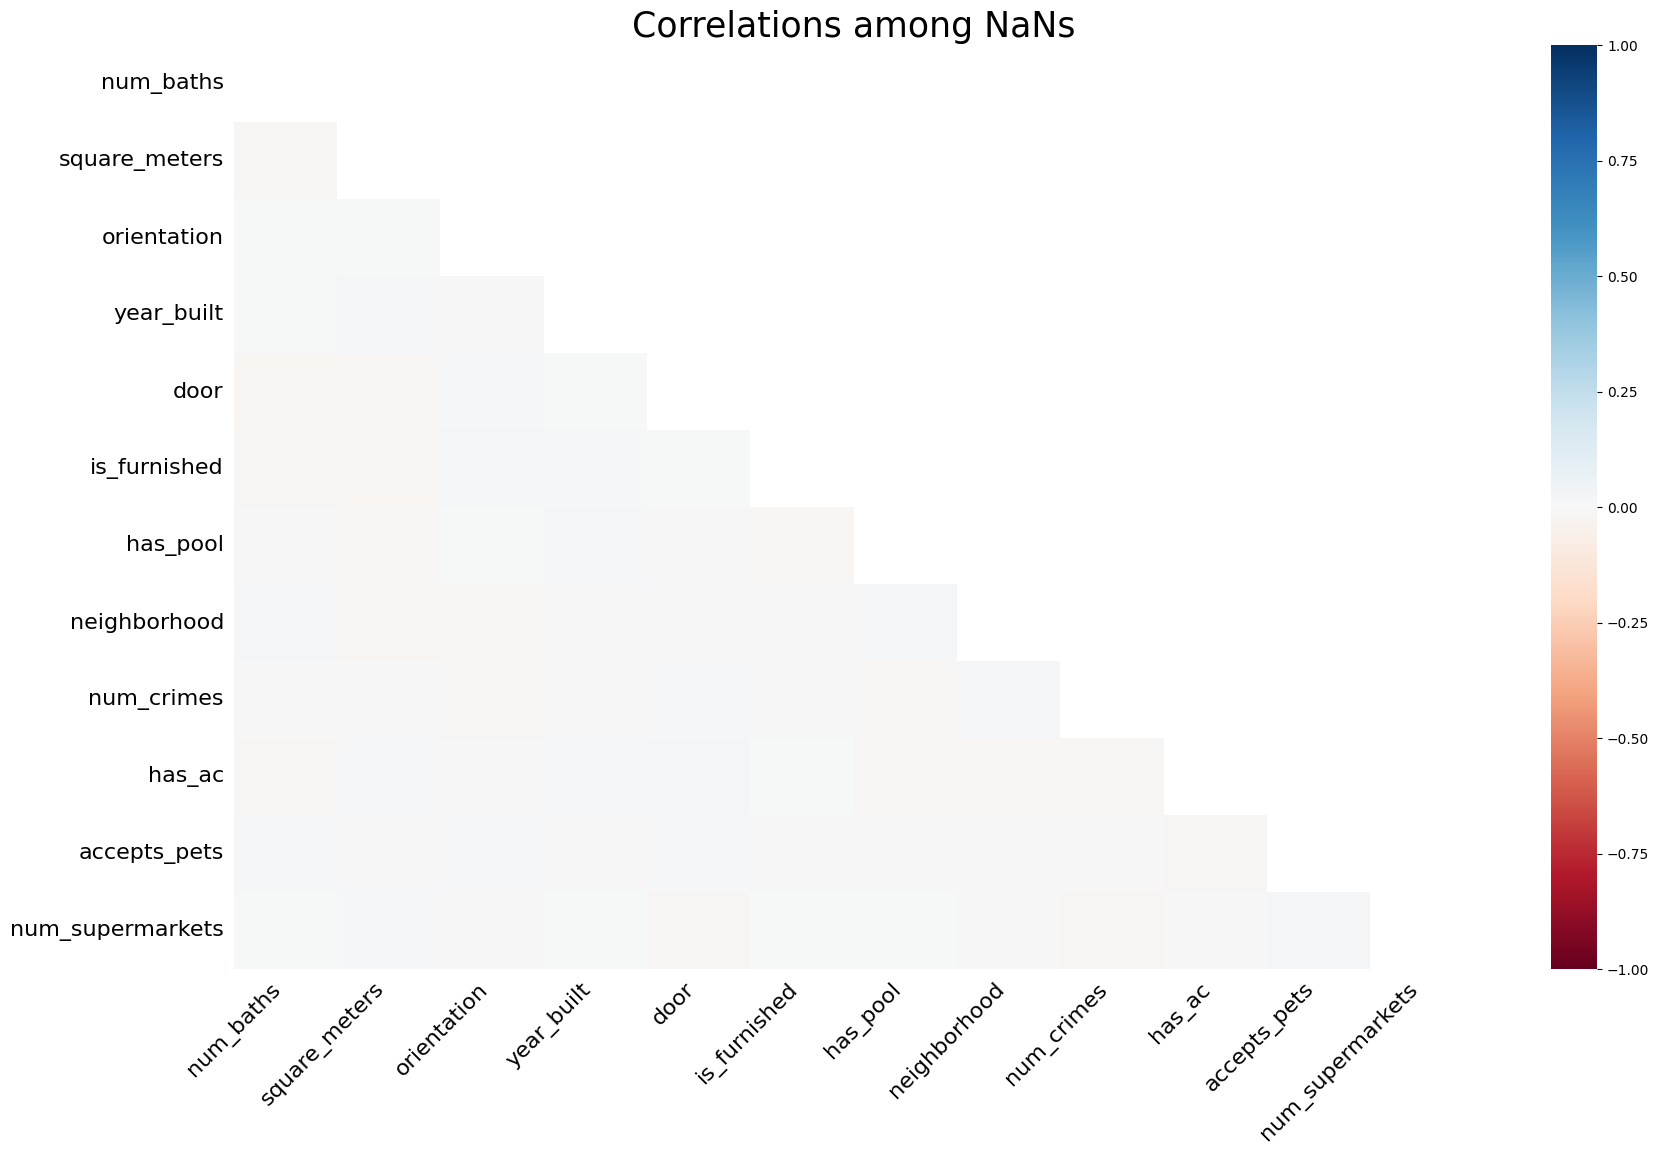

In [8]:
# Check, if there are correlations among NaNs
msno.heatmap(df)

plt.title('Correlations among NaNs', fontsize=25)
plt.show()

#### Missing Data in Train Data

We decided to show similar information as above but in a table format to be able to compare since we already have an idea of what to expect and check if the missing value pattern is the same between the train and test data.

In [9]:
# Function to create table of missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

                # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
missing_values_table(df_test)

Your selected dataframe has 14 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
num_supermarkets,1626,81.3
orientation,523,26.2
num_rooms,191,9.6
door,51,2.6
accepts_pets,45,2.2
has_pool,44,2.2
square_meters,43,2.2
num_baths,40,2.0
num_crimes,40,2.0
is_furnished,35,1.8


#### Recap of how we dealt with NA in our dataframe: 

|Column             |Technique|
|-----              |:-----|
|orientation        |one hot encoding and KNN then|
|num_baths          |imputed mean grouped by num_room|
|square_meters      |imputed mean grouped by num_room|
|year_built         |imputed mean grouped by neighbourhood|
|door               |missing values imputed 0 as constant|
|is_furnished       |KNN|
|has_pool           |KNN|
|num_supermarkets   |imputed mean grouped by neighbourhood|
|num_crimes         |imputed mean grouped by neighbourhood|
|has_ac             |KNN|
|accepts_pets       |KNN|
|neighborhood       |one hot encoding|


#### Mean Imputation grouped by another variable for NAs

We impute means grouped by neighborhood for year_built, num_supermarkets, num_crimes since we assume that houses in the same neighborhood may have the same level of crimes, same amount of nearby supermarkets

We impute means grouped by num_rooms for num_baths, square_meters that houses with the same num_rooms may have similar size and number of baths. 

In [11]:
# Function to calculate mean for the groups
def mean_group(df, column_groupby, columns_to_impute):
    groupby_mean = df.groupby(column_groupby)[columns_to_impute].transform('mean')
    df[columns_to_impute] = df[columns_to_impute].fillna(groupby_mean)
    return df #, groupby_mean

def mean_group_test(df, columns_to_impute, groupby_mean):
    df[columns_to_impute] = df[columns_to_impute].fillna(groupby_mean)
    return df

# Call the function to impute means grouped by neighbourhood
df = mean_group(df, 'neighborhood', ['year_built', 'num_supermarkets', 'num_crimes'])
df_test = mean_group(df_test, 'neighborhood', ['year_built', 'num_supermarkets', 'num_crimes'])

# Call the function to impute means grouped by num_rooms 
df = mean_group(df, 'num_rooms', ['num_baths', 'square_meters'])
df_test = mean_group(df_test, 'num_rooms', ['num_baths', 'square_meters'])

#### One Hot Encoding (using Get Dummies) for Neighborhood and Orientation

This makes binary columns for the different categories 

In [12]:
# What are the unique values in orientation
df['orientation'] = df['orientation'].replace('soxth', 'south') # fix typo in the data for south
df_test['orientation'] = df_test['orientation'].replace('soxth', 'south')
unique_values = df['orientation'].unique()
print('Unique Values in Orientation: ', unique_values)

# What are the unique values in neighborhood
unique_values = df['neighborhood'].unique()
print('Unique Values in Neighborhood: ', unique_values)

Unique Values in Orientation:  [nan 'west' 'east' 'north' 'south']
Unique Values in Neighborhood:  ['Sant Martí' 'Sants' 'Eixample' 'Gràcia' nan 'Les Cors'
 'Sarrià-Sant Gervasi' 'Horta' 'Sant Andreu' 'Ciutat Vella' 'Nou Barris']


In [13]:
def encode(df, columns_hot):
    encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    return encoded_df

# Execute function for df and df_test
df = encode(df, ['orientation', 'neighborhood'])
df_test = encode(df_test, ['orientation', 'neighborhood'])

#### Feature Engineering: Floor and Apartment from Door

The current door column is not usable because it contains text and numbers mixed together. We started by imputing NaN with 0. Then, we separated the floor number from the apartment number and created two columns with this information (only keeping the numberical values).

In [14]:
# Impute missing values with a constant (e.g., 0)
df['door'].fillna(0, inplace=True)
df_test['door'].fillna(0, inplace=True)

# Create features in order to use these columns for KNN as the next step
# Split the 'door' column into 'floor' and 'apartment' columns
df[['floor', 'apartment']] = df['door'].str.split(' - ', expand=True)
df_test[['floor', 'apartment']] = df_test['door'].str.split(' - ', expand=True)

# Remove any non-numeric characters from the 'apartment' column
df['apartment'] = df['apartment'].str.extract('(\d+)')
df_test['apartment'] = df_test['apartment'].str.extract('(\d+)')

# Remove '^0' from the 'floor' column
df['floor'] = df['floor'].str.replace('º', '', regex=True)
df_test['floor'] = df_test['floor'].str.replace('º', '', regex=True)

# Drop the 'door' column
df.drop(columns=['door'], inplace=True)
df_test.drop(columns=['door'], inplace=True)

# Print the updated DataFrame
df_test.head()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,...,neighborhood_Gràcia,neighborhood_Horta,neighborhood_Les Cors,neighborhood_Nou Barris,neighborhood_Sant Andreu,neighborhood_Sant Martí,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment
0,6253,NaN,1.0,152.0,2012.0,True,True,0.0,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,4
1,4685,NaN,2.0,90.0,1957.0,True,False,2.0,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,1
2,1732,NaN,2.0,86.0,1991.0,False,False,0.0,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2
3,4743,NaN,3.0,164.0,2002.0,False,True,7.0,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,4
4,4522,NaN,1.0,99.0,1984.0,True,True,0.0,True,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8,4


In [15]:
# Check unique values for the floor
unique_floor_values = df['floor'].unique()
print(unique_floor_values)

['3' '7' '1' '6' '5' '10' nan '2' '8' '4' '9']


#### KNN Imputation for Remaining NAs

We conducted a very simple tuning of the number of neighbors to use for kneighbors queries and settled on n_neighbors = 3; we also tested k=2 and k=4 but k=3 had the best final performance.

In [16]:
# Specify the columns to impute
columns_to_impute = ['num_rooms', 'num_baths', 'year_built', 'square_meters', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'floor', 'apartment']

# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute])

In [17]:
# check that there are no more null values
print('There are', df.isna().sum().sum(), 'NAs left in the train dataframe')
print('There are', df_test.isna().sum().sum(), 'NAs left in the test dataframe')

There are 0 NAs left in the train dataframe
There are 0 NAs left in the test dataframe


## 3. Addressing Outliers

In [18]:
# after checking unique values of square_meters, we noticed that there are negative values
print(df[(df['square_meters'] < 0)].shape[0], 'rows have negative values for square_meters')

# Remove the minuses in the column square_meters
df['square_meters'] = df['square_meters'].abs()
df_test['square_meters'] = df_test['square_meters'].abs()

81 rows have negative values for square_meters


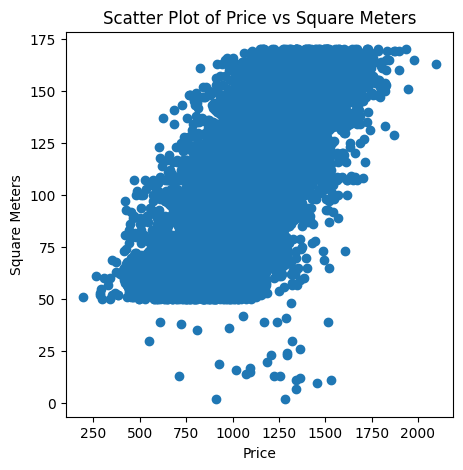

In [19]:
# Create a scatter plot to see, if there are strange values
plt.figure(figsize=(5, 5))  
plt.scatter(df['price'], df['square_meters'])
plt.xlabel('Price')
plt.ylabel('Square Meters')
plt.title('Scatter Plot of Price vs Square Meters')
plt.show()

#### Outliers in Number of Rooms and Square Meters

Treated through winsorization and mean imputation respectively below

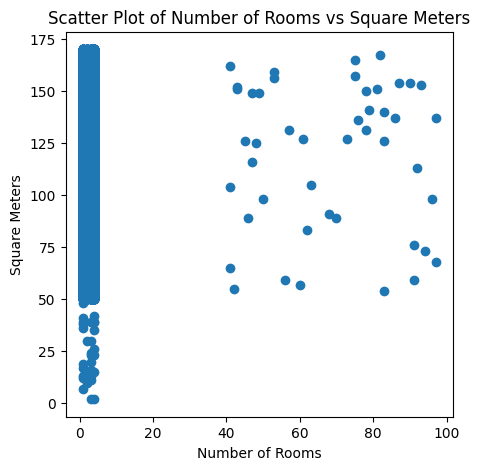

In [20]:
# Create a scatter plot to see, if there are strange values
plt.figure(figsize=(5, 5))  
plt.scatter(df['num_rooms'], df['square_meters'])
plt.xlabel('Number of Rooms')
plt.ylabel('Square Meters')
plt.title('Scatter Plot of Number of Rooms vs Square Meters')
plt.show()

In [21]:
# Number of strange values having viewed the box plot. 
count_small = len(df[df['square_meters'] < 50])
count = len(df['square_meters']) # total values
print('percentage of square_meters data that seem to be outliers:', (count_small/count)*100, '%')

percentage of square_meters data that seem to be outliers: 0.4 %


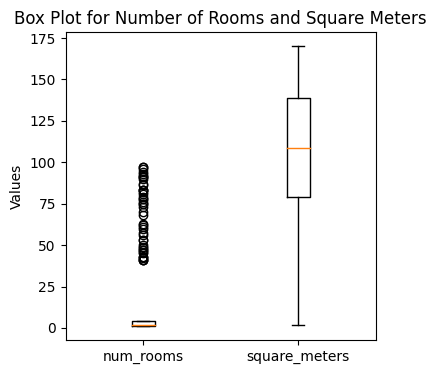

In [22]:
# Create a box plot for num_rooms and square_meters
plt.figure(figsize=(4, 4))  
plt.boxplot([df['num_rooms'], df['square_meters']], labels=['num_rooms', 'square_meters'])
plt.ylabel('Values')
plt.title('Box Plot for Number of Rooms and Square Meters')
plt.show()

#### Mean Imputation for Outliers in square_meters Column

In [23]:
# Calculate the median square_meters grouped by num_rooms
mean_square_meters = df.groupby('num_rooms')['square_meters'].transform('median')
mean_square_meters_test = df_test.groupby('num_rooms')['square_meters'].transform('median')

# Replace values less than 50 with the corresponding mean_square_meters
df['square_meters'] = df.apply(lambda row: mean_square_meters[round(row['num_rooms'])] if row['square_meters'] < 50 else row['square_meters'], axis=1)
df_test['square_meters'] = df_test.apply(lambda row: mean_square_meters_test[round(row['num_rooms'])] if row['square_meters'] < 50 else row['square_meters'], axis=1)

# Number of outliers having viewed the box plot.
count_small = len(df_test[df_test['square_meters'] < 50])
print('outliers remaining in square_meters after mean imputation:', count_small)

outliers remaining in square_meters after mean imputation: 0


#### Winsorizing Outliers in the num_rooms Column

In [24]:
# Number of outliers having viewd the box plot. 
count = len(df_test[df_test['num_rooms'] > 25])
print('outliers in num_rooms:', count)

# Calculate the 1st and 99th percentiles
first_percentile = df['num_rooms'].quantile(0.01)
ninety_ninth_percentile = df['num_rooms'].quantile(0.99)

# Windsorize the 'num_rooms' column
df['num_rooms'] = df['num_rooms'].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))
df_test['num_rooms'] = df_test['num_rooms'].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))

# Number of outliers remaining 
count = len(df_test[df_test['num_rooms'] > 25])
print('outliers in num_rooms after winsorizing:', count)

outliers in num_rooms: 55
outliers in num_rooms after winsorizing: 0


## 4. Standardize Columns

Standardization is the subtraction of the mean and then dividing by its standard deviation. Goal is that the different variables (used as regressors) have a similar scale so that variables with higher magnitutes don't dominate other features. 

In [25]:
def standardize(df, columns):
    for column in columns:
        df[column + '_standardized'] = (df[column] - df[column].mean()) / df[column].std()
        
    # Drop the original columns
    df.drop(columns=columns, inplace=True)
    return df

columns_to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'num_supermarkets', 'floor']
df = standardize(df, columns_to_standardize)
df_test = standardize(df_test, columns_to_standardize)

#### Correlations of all variables with price 

square meteres has the highest correlation with price of all the variables, will be interesting how that plays out in the feature importance in the model.

In [26]:
# Calculate the correlations of 'price' with all other columns
correlations = df.corr()['price']
print(correlations)

id                                  0.005516
is_furnished                        0.006594
has_pool                           -0.000141
has_ac                             -0.007530
accepts_pets                       -0.009956
price                               1.000000
orientation_east                   -0.010132
orientation_north                  -0.005406
orientation_south                   0.004248
orientation_west                   -0.001838
neighborhood_Ciutat Vella          -0.004134
neighborhood_Eixample               0.052924
neighborhood_Gràcia                 0.021665
neighborhood_Horta                  0.010224
neighborhood_Les Cors               0.032869
neighborhood_Nou Barris            -0.076136
neighborhood_Sant Andreu           -0.039443
neighborhood_Sant Martí            -0.038180
neighborhood_Sants                 -0.014445
neighborhood_Sarrià-Sant Gervasi    0.062495
apartment                          -0.018775
num_rooms_standardized              0.071772
num_baths_

## 5. Train & Test Models

### Split Data (Train/Test)

Important to note that we used a 70% (train) 30% (test) split. 

In [27]:
# drop id column: 
df = df.drop('id', axis = 1)
df_test_id = df_test[['id']]
df_test = df_test.drop('id', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.3, random_state=42)

### Linear Regression

In [28]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", round(train_mse,3), "Test MSE:", round(test_mse,3))
print("Train R^2:", round(train_r2,3), "Test R^2:", round(test_r2,3))

Train MSE: 29044.188 Test MSE: 30404.744
Train R^2: 0.607 Test R^2: 0.587


### Ridge Regression

In [29]:
# Train the model
model = Ridge(random_state=42)
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", round(train_mse,3), "Test MSE:", round(test_mse,3))
print("Train R^2:", round(train_r2,3), "Test R^2:", round(test_r2,3))

Train MSE: 29044.192 Test MSE: 30404.27
Train R^2: 0.607 Test R^2: 0.587


### Lasso Regression

In [30]:
# Train the model
model = Lasso(random_state=42)
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", round(train_mse,3), "Test MSE:", round(test_mse,3))
print("Train R^2:", round(train_r2,3), "Test R^2:", round(test_r2,3))

Train MSE: 29099.405 Test MSE: 30237.507
Train R^2: 0.606 Test R^2: 0.589


### Hyperparameter Tuning (finding 'best' alpha)

Tuning Lasso Model since the Test MSE was the lowest  and Test R^2 was the highest.

In [31]:
# hyperparameter tuning: deciding which alpha to use in Lasso Model
for a in  [1,1.5,2,2.5,3]:
    model = Lasso(random_state=42, alpha = a)

    model.fit(X_train, y_train)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Compute metrics
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    print("alpha:", a)
    print("Train MSE:", round(train_mse,3), "Test MSE:", round(test_mse,3))
    print("Train R^2:", round(train_r2,3), "Test R^2:", round(test_r2,3))    
    print()

alpha: 1
Train MSE: 29099.405 Test MSE: 30237.507
Train R^2: 0.606 Test R^2: 0.589

alpha: 1.5
Train MSE: 29119.136 Test MSE: 30236.351
Train R^2: 0.606 Test R^2: 0.589

alpha: 2
Train MSE: 29137.018 Test MSE: 30246.62
Train R^2: 0.606 Test R^2: 0.589

alpha: 2.5
Train MSE: 29148.247 Test MSE: 30254.571
Train R^2: 0.606 Test R^2: 0.589

alpha: 3
Train MSE: 29161.971 Test MSE: 30265.039
Train R^2: 0.605 Test R^2: 0.589



## 6. Run Final Model 

Get predictions for the actual test dataframe by rerunning best model (Lasso with alpha 1.5) on the entire train dataframe

In [32]:
# run chosen model on entire train dataframe
model = Lasso(random_state=42, alpha = 1.5 )
model.fit(df.drop('price', axis=1), df['price'])

# predict test values
test_predictions = model.predict(df_test)

# create csv file with results to submit
test_prediction_submit = pd.DataFrame({"id": df_test_id["id"],  "price": test_predictions})
test_prediction_submit.to_csv("test_submit.csv", index = False)

## 7. Conclusion: Identifying Impactful Variables

The chosen model, LASSO, drove down coefficients to 0 of the majority of variables. The remaining variables in order of importance are: square_meters_standardized, num_crimes_standardized, floor_standardized, num_rooms_standardized, num_baths_standardized, has_ac, has_pool, num_supermarkets_standardized. The effects of has_ac, has_pool, and num_supermarkets_standardized are practically negligeable with coefficients under 1. However, the square meters and number of crimes are the most impactful variables by far with coefficients of 190 and -75 respectively. This intuitively makes sense, as a bigger house/apartment likely costs more and the number of crimes is a good indicator of how safe a location is (safer would be more expensive).


In [33]:
# get and sort values of coefficients in ascending order 
pd.DataFrame({'feature':model.feature_names_in_, 'coefficient':model.coef_}).sort_values('coefficient')

,feature,coefficient
23,num_crimes_standardized,-74.945671
0,is_furnished,0.000000
22,year_built_standardized,-0.000000
18,apartment,-0.000000
17,neighborhood_Sarrià-Sant Gervasi,-0.000000
16,neighborhood_Sants,-0.000000
15,neighborhood_Sant Martí,-0.000000
14,neighborhood_Sant Andreu,-0.000000
13,neighborhood_Nou Barris,-0.000000
11,neighborhood_Horta,0.000000
